In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
from PIL import Image

def overlapping_area_coordinates(image1: Image, image2: Image):
    import sys 
    min_x1, min_y1 = sys.maxsize, sys.maxsize
    for (x0, y0, x1, y1) in [image1.getbbox(), image2.getbbox()]:
        if x1 < min_x1:
            min_x1 = x1
        if y1 < min_y1:
            min_y1 = y1
    return min_x1, min_y1

def split_image(image: Image, tile_width: int = 128, tile_height: int = 32):
    """
    Splits an image into tiles of specified width and height. Discards the left edge pixels to make the
    width divisible by 128.

    Args:
    - image (PIL.Image): The input image.
    - tile_width (int): The desired width of each tile. Default is 128.
    - tile_height (int): The desired height of each tile.

    Returns:
    - List[Image]: A list of PIL Image objects representing the tiles.
    """
    # Calculate the amount of width to discard so the remaining width is divisible by tile_width
    discard_width = image.width % tile_width
    start_x = discard_width

    images = []
    # Adjust the starting x position to discard the left edge until the width is divisible by 128
    for x in range(start_x, image.width, tile_width):
        for y in range(0, image.height, tile_height):
            # Check if the current crop will fit within the image dimensions
            if x + tile_width <= image.width and y + tile_height <= image.height:
                images.append(image.crop((x, y, x + tile_width, y + tile_height)))

    return images

In [23]:
train_features = Image.open('train_features.png').convert('RGB')
train_ground_truth = Image.open('train_ground_truth.png').convert('L')

### Training area features

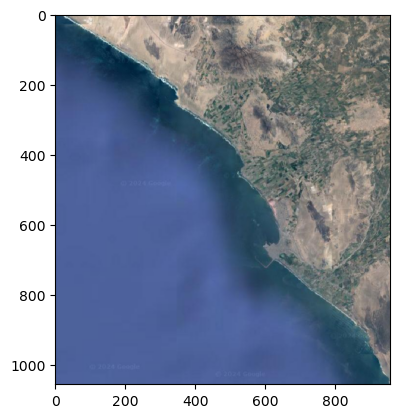

In [24]:
import matplotlib.pyplot as plt
plt.imshow(train_features)

### Training area ground truth

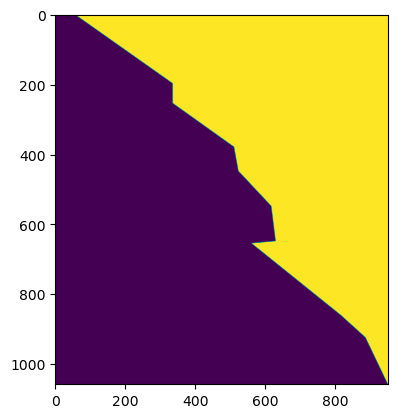

In [25]:
plt.imshow(train_ground_truth)

In [3]:
width, height = overlapping_area_coordinates(train_features, train_ground_truth)
# crop both images with their intersection
train_features = train_features.crop((0, 0, width, height))
train_ground_truth = train_ground_truth.crop((0, 0, width, height))

# split train_features and train_ground_truth into smaller images of 128x32
train_features = split_image(train_features, 128, 32)
train_ground_truth = split_image(train_ground_truth, 128, 32)
len(train_features), len(train_ground_truth)

(231, 231)

In [4]:
validation_features = Image.open('validation_features.png').convert('RGB')
validation_ground_truth = Image.open('validation_ground_truth.png').convert('L')
width, height = overlapping_area_coordinates(validation_features, validation_ground_truth)
validation_features = validation_features.crop((0, 0, width, height))
validation_ground_truth = validation_ground_truth.crop((0, 0, width, height))

# split train_features and train_ground_truth into smaller images of 128x32
validation_features = split_image(validation_features, 128, 32)
validation_ground_truth = split_image(validation_ground_truth, 128, 32)
len(validation_features), len(validation_ground_truth)

(84, 84)

In [5]:
from PIL import Image

def overlapping_area_coordinates(image1: Image, image2: Image):
    import sys 
    min_x1, min_y1 = sys.maxsize, sys.maxsize
    for (x0, y0, x1, y1) in [image1.getbbox(), image2.getbbox()]:
        if x1 < min_x1:
            min_x1 = x1
        if y1 < min_y1:
            min_y1 = y1
    return min_x1, min_y1

# load images with DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import os
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader, Dataset

class ImageMaskDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None, mask_transform=None):
        """
        Args:
            image_list (list): List of PIL images.
            mask_list (list): List of PIL masks corresponding to the images.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        mask = self.mask_list[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return {'image': image, 'mask': mask}

from collections import defaultdict

class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        self.outputs = defaultdict(list)

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Log the shapes of outputs and targets
        print("logits_mask shape:", logits_mask.shape)
        print("mask shape:", mask.shape)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)     
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        metrics = {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
        
        self.outputs[stage].append(metrics)

        return metrics

    def shared_epoch_end(self, stage):
        outputs = self.outputs[stage]
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)
        
        self.outputs[stage].clear()

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


train_features = Image.open('train_features.png').convert('RGB')
train_ground_truth = Image.open('train_ground_truth.png').convert('L')

width, height = overlapping_area_coordinates(train_features, train_ground_truth)
# crop both images with their intersection
train_features = train_features.crop((0, 0, width, height))
train_ground_truth = train_ground_truth.crop((0, 0, width, height))

# split train_features and train_ground_truth into smaller images of 128x32
train_features = split_image(train_features, 128, 32)
train_ground_truth = split_image(train_ground_truth, 128, 32)

validation_features = Image.open('validation_features.png').convert('RGB')
validation_ground_truth = Image.open('validation_ground_truth.png').convert('L')
width, height = overlapping_area_coordinates(validation_features, validation_ground_truth)
validation_features = validation_features.crop((0, 0, width, height))
validation_ground_truth = validation_ground_truth.crop((0, 0, width, height))

# split train_features and train_ground_truth into smaller images of 128x32
validation_features = split_image(validation_features, 128, 32)
validation_ground_truth = split_image(validation_ground_truth, 128, 32)


train_dataset = ImageMaskDataset(train_features, train_ground_truth, transform=transforms.ToTensor(), mask_transform=transforms.ToTensor())
valid_dataset = ImageMaskDataset(validation_features, validation_ground_truth, transform=transforms.ToTensor(), mask_transform=transforms.ToTensor())
    
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=0)

model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)
trainer = pl.Trainer(
    max_epochs=10,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kristjan.roosild/opt/anaconda3/envs/segmodel/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated mode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/kristjan.roosild/opt/anaconda3/envs/segmodel/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])


/Users/kristjan.roosild/opt/anaconda3/envs/segmodel/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/kristjan.roosild/opt/anaconda3/envs/segmodel/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([103, 1, 32, 128])
mask shape: torch.Size([103, 1, 32, 128])


Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])


`Trainer.fit` stopped: `max_epochs=10` reached.


In [6]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

Validation: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([84, 1, 32, 128])
mask shape: torch.Size([84, 1, 32, 128])
[{'valid_dataset_iou': 0.9626417756080627,
  'valid_per_image_iou': 0.9264024496078491}]


In [7]:
test_features = Image.open('test_features.png').convert('RGB')
test_gt = Image.open('test_gt.png').convert('L')

test_features.width, test_features.height, test_gt.width, test_gt.height

(3508, 2274, 3508, 2274)

In [8]:
test_features = split_image(test_features, 128, 32)
test_gt = split_image(test_gt, 128, 32)
len(test_features), len(test_gt)

(1917, 1917)

In [9]:
test_dataset = ImageMaskDataset(test_features, test_gt, transform=transforms.ToTensor(), mask_transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

In [10]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

/Users/kristjan.roosild/opt/anaconda3/envs/segmodel/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])
logits_mask shape: torch.Size([128, 1, 32, 128])
mask shape: torch.Size([128, 1, 32, 128])

In [11]:
from PIL import Image

# Example usage
# Assuming 'split_images' is a list of images returned by the split_image function
# and you know the original dimensions and tile size
test_features_image = Image.open('test_features.png')
original_width = test_features_image.width  # Example original width
original_height = test_features_image.height  # Example original height
tile_width = 128  # Width of each tile
tile_height = 32  # Height of each tile



In [41]:
import numpy as np
feature_images = []
test_ground_truth_images = []
prediction_images = []
with torch.no_grad():
    model.eval()
    for batch in iter(test_dataloader):
        logits = model(batch["image"])
        pr_masks = logits.sigmoid()

        for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
            feature_image = Image.fromarray((image.numpy().transpose(1, 2, 0)*255).astype(np.uint8))
            gt_image = Image.fromarray((gt_mask.numpy().squeeze()*255).astype(np.uint8))
            prediction_image = Image.fromarray((pr_mask.numpy().squeeze()*255).astype(np.uint8))
            feature_images.append(feature_image)
            test_ground_truth_images.append(gt_image)
            prediction_images.append(prediction_image)
    

In [27]:
def merge_images_column_major(images, original_width, original_height, tile_width, tile_height):
    """
    Reconstruct the original image from its segments arranged in column-major order.
    
    Args:
    - images (list of Image): The list of PIL Image objects, ordered in column-major.
    - original_width (int): The width of the original image.
    - original_height (int): The height of the original image.
    - tile_width (int): The width of each tile.
    - tile_height (int): The height of each tile.
    
    Returns:
    - Image: The reconstructed PIL Image.
    """
    merged_image = Image.new('RGB', (original_width, original_height))
    num_tiles_per_col = original_height // tile_height

    for i, img in enumerate(images):
        x = (i // num_tiles_per_col) * tile_width
        y = (i % num_tiles_per_col) * tile_height
        merged_image.paste(img, (x, y))

    return merged_image

### Test area features

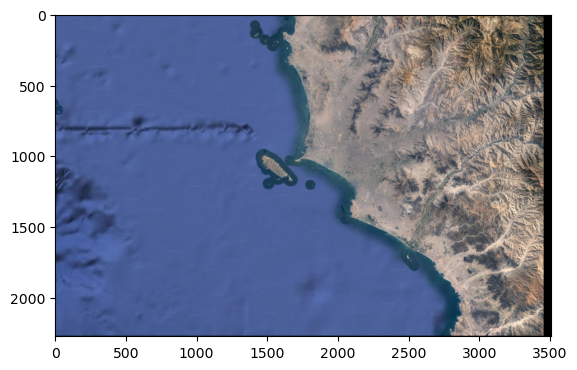

In [28]:
whole_image = merge_images_column_major(feature_images, original_width, original_height, tile_width, tile_height)
plt.imshow(whole_image)

### Test area ground truth

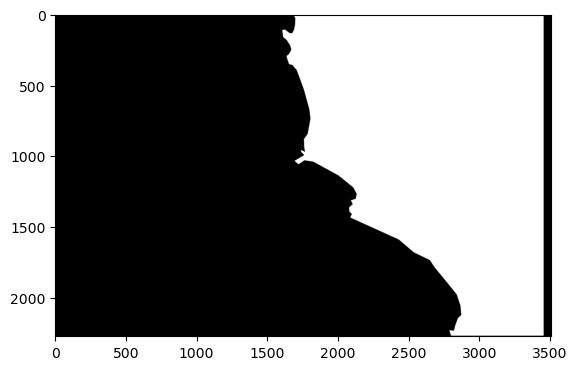

In [45]:
gt = merge_images_column_major(test_ground_truth_images, original_width, original_height, tile_width, tile_height)
plt.imshow(gt)

### Test area prediction

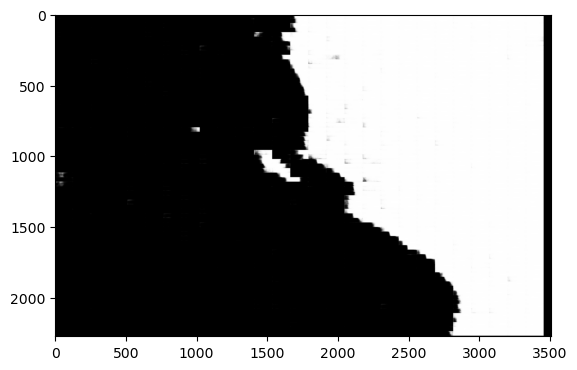

In [29]:
whole_image = merge_images_column_major(prediction_images, original_width, original_height, tile_width, tile_height)
plt.imshow(whole_image)